# Notebook to create 2D initial conditions to Mandyoc

In [1]:
# from functions.coordinates import grid_coordinates, create_grid
# from functions.interfaces import create_interface, interface_from_vertices, merge_interfaces
# from functions.io.interfaces import save_interfaces
# from functions.io.temperature import save_temperature

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from functions.coordinates import grid_coordinates, create_grid
from functions.interfaces import create_interface, interface_from_vertices, merge_interfaces
from functions.io.interfaces import save_interfaces
from functions.io.temperature import save_temperature

Create a directory to save the input files:

In [2]:
run_dir = os.path.join("input")
if not os.path.isdir(run_dir):
    os.makedirs(run_dir)

Define and create the mesh geometry:

In [3]:
xmin, xmax, zmin, zmax = 0, 11600e3, -2940e3, 0.0e3  # m
region = (xmin, xmax, zmin, zmax)
shape = (1161, 736)

# Create the coordinates for the region
coordinates = grid_coordinates(region, shape)
coordinates

Coordinates:
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.158e+07 1.159e+07 1.16e+07
  * z        (z) float64 -2.94e+06 -2.936e+06 -2.932e+06 ... -8e+03 -4e+03 0.0

## Interfaces

In [4]:
# Air layer [m]
h_air = -40.0e3

# Lower boundary of the astenosphere [m]
lower_boundary_astenosphere = -660e3  

# Non-subduction oceanic plate [m]
oceanic_lab_depth = -80e3  
oceanic_crust_depth = -10e3  
oceanic_thin_length = 200e3  

# Subducting slab portion [m]
slab_slope = 29  # °
slab_length = 200e3  # Length of subducted slab
slab_xmax = 5700e3  

slab_slope_rad = slab_slope * np.pi / 180 
slab_zmax = - slab_length * np.sin(slab_slope_rad)    # Maximum depth reached by the slab (~ 100 km below the surface)  
slab_xmin = slab_xmax - np.cos(slab_slope_rad) * slab_length  # x position where the slab begins to subduct 

# Continental arc region [m]
arc_length = 1300e3 
arc_depth = -60e3  

# Non-arc continental region [m]
# Cratoic region
continental_lab_depth = -150e3  
continental_upper_crust_depth = -30e3   
craton_thin_length = 1600e3

# Craton transition
transition_xmin = slab_xmin + arc_length 
transition_xlength = 200e3
transition_xmax = transition_xmin + transition_xlength
a = (continental_lab_depth - arc_depth) / transition_xlength
b = arc_depth - a * transition_xmin
transition_xmidle = (slab_zmax - b) / a

**Lower mantle**

In [5]:
lower_mantle = create_interface(
    coordinates, 
    fill_value=lower_boundary_astenosphere,
    compositional_factor=1.0,
    density=3378.0,
    radiogenic_heat=0.0,
    pre_exponential_scale_factor=1.393e-14,
    power_law_exponent=3.0,
    activation_energy=429.0e3,
    activation_volume=15.0e-6,
)

**Astenosphere 1**

In [6]:
astenosphere_1_vertices = [
    [xmin, zmax],
    [xmin + oceanic_thin_length, oceanic_lab_depth],
    [slab_xmin, oceanic_lab_depth],
    [slab_xmax, oceanic_lab_depth + slab_zmax],
    [slab_xmax, slab_zmax],
    [transition_xmidle, slab_zmax],
    [transition_xmax, continental_lab_depth],
    [xmax - craton_thin_length, continental_lab_depth],
    [xmax, zmax],
]

astenosphere_1 = interface_from_vertices(
    astenosphere_1_vertices,
    coordinates,
    compositional_factor=1.0,
    density=3378.0,
    radiogenic_heat=0.0,
    pre_exponential_scale_factor=1.393e-14,
    power_law_exponent=3.0,
    activation_energy=429.0e3,
    activation_volume=15.0e-6,
)

**Oceanic lithospheric mantle**

In [7]:
oceanic_lithospheric_mantle = astenosphere_1.copy() + abs(oceanic_lab_depth - oceanic_crust_depth)

oceanic_lithospheric_mantle = xr.where(
    oceanic_lithospheric_mantle.x >= slab_xmax,
    astenosphere_1,
    oceanic_lithospheric_mantle
)

oceanic_lithospheric_mantle = xr.where(
    oceanic_lithospheric_mantle.x <= xmin + oceanic_thin_length,
    oceanic_crust_depth,
    oceanic_lithospheric_mantle
)

oceanic_lithospheric_mantle = xr.where(
    (oceanic_lithospheric_mantle <= astenosphere_1) & (oceanic_lithospheric_mantle.x <= xmin + oceanic_thin_length),
    astenosphere_1,
    oceanic_lithospheric_mantle
)

oceanic_lithospheric_mantle.attrs = {"compositional_factor":1.0,
                                     "density":3354.0,
                                     "radiogenic_heat":9.0e-12,
                                     "pre_exponential_scale_factor":2.4168e-15,
                                     "power_law_exponent":3.5,
                                     "activation_energy":540.0e3,
                                     "activation_volume":25.0e-6,}

**Oceanic crust**

In [8]:
oceanic_crust_density = 2800.0
oceanic_crust = oceanic_lithospheric_mantle.copy() + abs(oceanic_crust_depth)

oceanic_crust = xr.where(
    oceanic_crust.x >= slab_xmax,
    oceanic_lithospheric_mantle,
    oceanic_crust
)

oceanic_crust = xr.where(
    oceanic_crust.x <= xmin + oceanic_thin_length,
    zmax,
    oceanic_crust
)
oceanic_crust.attrs = {"compositional_factor":0.01,
                       "density":oceanic_crust_density,
                       "radiogenic_heat":0.8e-6/oceanic_crust_density,
                       "pre_exponential_scale_factor":8.574e-28,
                       "power_law_exponent":4.0,
                       "activation_energy":222.0e3,
                       "activation_volume":0.0,}

**Astenosphere 2**

In [9]:
slab_xmidle = slab_xmin +  arc_depth / np.tan(slab_slope_rad)

astenosphere_2_vertices = [
    [xmin, arc_depth],
    [slab_xmin, arc_depth],
    [transition_xmin, arc_depth],
    [transition_xmax, continental_lab_depth],
    [xmax, continental_lab_depth],
]

astenosphere_2 = interface_from_vertices(
    astenosphere_2_vertices, 
    coordinates
)

astenosphere_2 = xr.where(
    astenosphere_2 <= oceanic_crust,
    oceanic_crust,
    astenosphere_2
)

astenosphere_2.attrs = {"compositional_factor":1.0,
                        "density":3378,
                        "radiogenic_heat":0.0,
                        "pre_exponential_scale_factor":1.393E-14,
                        "power_law_exponent":3.0,
                        "activation_energy":429.0e3,
                        "activation_volume":15.0e-6,}

**Continental lithospheric mantle**

In [10]:
continental_lithospheric_mantle_vertices = [
    [xmin, continental_upper_crust_depth],
    [xmax, continental_upper_crust_depth]
]

continental_lithospheric_mantle = interface_from_vertices(
    continental_lithospheric_mantle_vertices, 
    coordinates
)

continental_lithospheric_mantle = xr.where(
    continental_lithospheric_mantle <= oceanic_crust,
    oceanic_crust,
    continental_lithospheric_mantle
)

continental_lithospheric_mantle.attrs = {"compositional_factor":1.0,
                                         "density":3354,
                                         "radiogenic_heat":9.0e-12,
                                         "pre_exponential_scale_factor":2.4168E-15,
                                         "power_law_exponent":3.5,
                                         "activation_energy":540.0e3,
                                         "activation_volume":25.0e-6,}

**Continental crust**

In [11]:
continental_crust_density = 2700.0

continental_crust = create_interface(
    coordinates,
    fill_value=h_air,
    compositional_factor=1.0,
    density=continental_crust_density,
    radiogenic_heat=2.5E-6/continental_crust_density,
    pre_exponential_scale_factor=8.574e-28,
    power_law_exponent=4.0,
    activation_energy=222.0e3,
    activation_volume=0.0,
)

**Air layer**

In [12]:
air_layer = create_interface(
    coordinates,
    fill_value=0.0,
    compositional_factor=1.0,
    density=1.0,
    radiogenic_heat=0.0,
    pre_exponential_scale_factor=0.0,
    power_law_exponent=0.0,
    activation_energy=0.0,
    activation_volume=0.0,
)

In [13]:
print(80*'=', '\nair_layer')
print(80*'=', '\n', air_layer)
print(80*'=', '\nlower_mantle')
print(80*'=', '\n', lower_mantle)
lower_mantle.values += h_air
print(80*'=', '\nastenosphere_1')
print(80*'=', '\n', astenosphere_1)
astenosphere_1.values += h_air
print(80*'=', '\noceanic_lithospheric_mantle')
print(80*'=', '\n', oceanic_lithospheric_mantle)
oceanic_lithospheric_mantle.values += h_air
print(80*'=', '\noceanic_crust')
print(80*'=', '\n', oceanic_crust)
oceanic_crust.values += h_air
print(80*'=', '\nastenosphere_2')
print(80*'=', '\n', astenosphere_2)
astenosphere_2.values += h_air
print(80*'=', '\ncontinental_lithospheric_mantle')
print(80*'=', '\n', continental_lithospheric_mantle)
continental_lithospheric_mantle.values += h_air

air_layer
 <xarray.DataArray (x: 1161)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.158e+07 1.159e+07 1.16e+07
Attributes:
    compositional_factor:          1.0
    density:                       1.0
    radiogenic_heat:               0.0
    pre_exponential_scale_factor:  0.0
    power_law_exponent:            0.0
    activation_energy:             0.0
    activation_volume:             0.0
lower_mantle
 <xarray.DataArray (x: 1161)>
array([-660000., -660000., -660000., ..., -660000., -660000., -660000.])
Coordinates:
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.158e+07 1.159e+07 1.16e+07
Attributes:
    compositional_factor:          1.0
    density:                       3378.0
    radiogenic_heat:               0.0
    pre_exponential_scale_factor:  1.393e-14
    power_law_exponent:            3.0
    activation_energy:             429000.0
    activation_volume:             1.5e-05
astenosphere_1
 <xarray.DataArray

***Merge all interfaces in a xr.Datarray***

In [14]:
lower_mantle
interfaces = merge_interfaces(
    {
        "lower_mantle_top": lower_mantle,
        "astenosphere_1_top": astenosphere_1,
        "oceanic_lithospheric_mantle_top": oceanic_lithospheric_mantle,
        "oceanic_crust_top": oceanic_crust,
        "astenosphere_2_top": astenosphere_2,
        "continental_lithospheric_mantle_top": continental_lithospheric_mantle,
        "continental_crust_top": continental_crust,
    }
)
print(interfaces)

<xarray.Dataset>
Dimensions:                              (x: 1161)
Coordinates:
  * x                                    (x) float64 0.0 1e+04 ... 1.16e+07
Data variables:
    lower_mantle_top                     (x) float64 -7e+05 -7e+05 ... -7e+05
    astenosphere_1_top                   (x) float64 -4e+04 -4.4e+04 ... -4e+04
    oceanic_lithospheric_mantle_top      (x) float64 -4e+04 -4.4e+04 ... -4e+04
    oceanic_crust_top                    (x) float64 -4e+04 -4e+04 ... -4e+04
    astenosphere_2_top                   (x) float64 -4e+04 -4e+04 ... -4e+04
    continental_lithospheric_mantle_top  (x) float64 -4e+04 -4e+04 ... -4e+04
    continental_crust_top                (x) float64 -4e+04 -4e+04 ... -4e+04


**Plot the interfaces**

In [15]:
len(interfaces.keys())

7

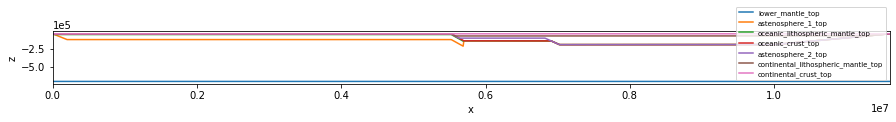

In [16]:
fig, ax = plt.subplots(
    figsize=(15,20)
)

# Change the orientation of the color bar
cbar_kwargs = {"orientation": "horizontal"}
kwargs = {"cbar_kwargs": cbar_kwargs}

# Tnterfaces
for name, interface in interfaces.items():
    interface.plot.line(ax=ax, label=name)
plt.legend(loc="lower right", fontsize="x-small")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
ax.set_aspect("equal")
plt.xlim((xmin-1.0e3, xmax+1.0e3))
#plt.ylim((zmin, 100e3))
plt.ylabel("z")

plt.savefig("full.pdf")
plt.show()

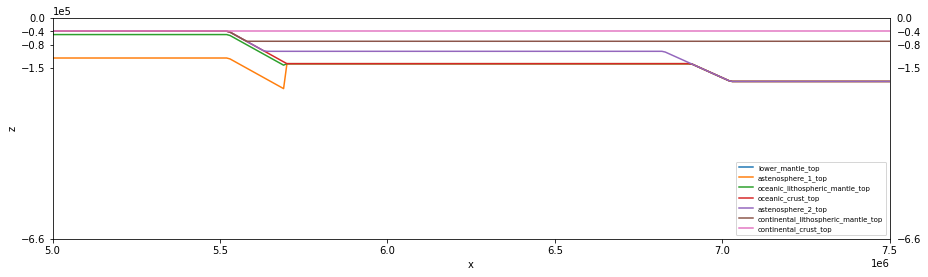

In [17]:
fig, ax = plt.subplots(
    figsize=(15,20)
)

# Change the orientation of the color bar
cbar_kwargs = {"orientation": "horizontal"}
kwargs = {"cbar_kwargs": cbar_kwargs}

# Tnterfaces
for name, interface in interfaces.items():
    interface.plot.line(ax=ax, label=name)
plt.legend(loc="lower right", fontsize="x-small")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
ax.set_aspect("equal")
ax.tick_params(labelleft=True, labelright=True)
plt.xlim((5000e3, 7500e3))

plt.ylim((-250e3, 100))
plt.yticks([0,h_air,oceanic_lab_depth,continental_lab_depth,lower_boundary_astenosphere])
plt.ylabel("z")

plt.show()
# plt.savefig("figure.pdf")

**Save the interface**

In [18]:
layers_data = {
    "compositional_factor": [lower_mantle.compositional_factor, 
                             astenosphere_1.compositional_factor,
                             oceanic_lithospheric_mantle.compositional_factor,
                             oceanic_crust.compositional_factor,
                             astenosphere_2.compositional_factor,
                             continental_lithospheric_mantle.compositional_factor,
                             continental_crust.compositional_factor,
                             air_layer.compositional_factor,],
    "density": [lower_mantle.density,
                astenosphere_1.density,
                oceanic_lithospheric_mantle.density,
                oceanic_crust.density,
                astenosphere_2.density,
                continental_lithospheric_mantle.density,
                continental_crust.density,
                air_layer.density,],
    "radiogenic_heat": [lower_mantle.radiogenic_heat,
                        astenosphere_1.radiogenic_heat,
                        oceanic_lithospheric_mantle.radiogenic_heat,
                        oceanic_crust.radiogenic_heat,
                        astenosphere_2.radiogenic_heat,
                        continental_lithospheric_mantle.radiogenic_heat,
                        continental_crust.radiogenic_heat,
                        air_layer.radiogenic_heat,],
    "pre-exponential_scale_factor": [lower_mantle.pre_exponential_scale_factor,
                                     astenosphere_1.pre_exponential_scale_factor,
                                     oceanic_lithospheric_mantle.pre_exponential_scale_factor,
                                     oceanic_crust.pre_exponential_scale_factor,
                                     astenosphere_2.pre_exponential_scale_factor,
                                     continental_lithospheric_mantle.pre_exponential_scale_factor,
                                     continental_crust.pre_exponential_scale_factor,
                                     air_layer.pre_exponential_scale_factor,],
    "power_law_exponent": [lower_mantle.power_law_exponent,
                           astenosphere_1.power_law_exponent,
                           oceanic_lithospheric_mantle.power_law_exponent,
                           oceanic_crust.power_law_exponent,
                           astenosphere_2.power_law_exponent,
                           continental_lithospheric_mantle.power_law_exponent,
                           continental_crust.power_law_exponent,
                           air_layer.power_law_exponent,],
    "activation_energy": [lower_mantle.activation_energy,
                          astenosphere_1.activation_energy,
                          oceanic_lithospheric_mantle.activation_energy,
                          oceanic_crust.activation_energy,
                          astenosphere_2.activation_energy,
                          continental_lithospheric_mantle.activation_energy,
                          continental_crust.activation_energy,
                          air_layer.activation_energy,],
    "activation_volume": [lower_mantle.activation_volume,
                          astenosphere_1.activation_volume,
                          oceanic_lithospheric_mantle.activation_volume,
                          oceanic_crust.activation_volume,
                          astenosphere_2.activation_volume,
                          continental_lithospheric_mantle.activation_volume,
                          continental_crust.activation_volume,
                          air_layer.activation_volume,],
}

# Save data
save_interfaces(interfaces, layers_data, run_dir)

## Initial temperature model

Create the temperature dataset

In [19]:
temperature = create_grid(coordinates, fill_value=0)
temperature

<xarray.DataArray (x: 1161, z: 736)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.158e+07 1.159e+07 1.16e+07
  * z        (z) float64 -2.94e+06 -2.936e+06 -2.932e+06 ... -8e+03 -4e+03 0.0

Trace LAB without the subducted lithosphere

In [20]:
lid_vertices = [
    [xmin, zmax + h_air],
    [xmin + oceanic_thin_length, oceanic_lab_depth + h_air],
    [slab_xmin, oceanic_lab_depth + h_air],
    [slab_xmax, arc_depth + h_air],
    [transition_xmin, arc_depth + h_air],
    [transition_xmax, continental_lab_depth + h_air],
    [xmax - craton_thin_length, continental_lab_depth + h_air],
    [xmax, zmax + h_air]
]

lid = interface_from_vertices(lid_vertices, coordinates)

Temperature is constant for the air layer
$$ T(z<h_{air}) = 0.0 $$
where $h_{air}$ is the thickness of the air layer.

Temperature increases linearly with depth for the lithosphere
$$ T(h_{air}\leq z\leq h_{litho}) = -T_{LAB} \frac{(z+h_{air})}{h_{air}+h_{litho}} $$
where $h_{litho}$ is the thickness of the lithosphere, and $T_{LAB}=1300^{\circ}$C is the temperature at the base of the lithosphere.

In the asthenosphere, the temperature is the adiabatic temperature.

In [21]:
temp_LAB = 1300.0  # °
temp_air = 0.0 # °
heat_capacity = 1250  # Cp m2/Ks2 
alpha = 3.28E-5  # thermal expansion coefficient 1/K 
g = 9.8  # gravity m/s2
temp_0 = 1262.0  # °
particles_per_element = 30
kappa = 1.0e-6

In [22]:
# Functions to calculate temperature
constant = 0.0
linear = temp_LAB * (h_air - temperature.z) / abs(lid - h_air)
adiabatic = temp_0 / np.exp(- g * alpha * (h_air - temperature.z) / heat_capacity)

In [23]:
# Transposee the temperature to fix the dimension
temperature = temperature.transpose("x", "z") 

# Set lithosphere temperature to 'linear' and astenosphere and lower mantle temperatures to 'adiabatic'
linear_or_adiabatic = xr.where(
    temperature.z >= lid,
    linear,
    adiabatic
)

# Set air layer temperature to 0.0
temperature = xr.where(
    temperature.z >= h_air,
    constant,
    linear_or_adiabatic
)

# Set maximum temperature profile to 'adiabatic'
temperature = xr.where(
    temperature > adiabatic,
    adiabatic, 
    temperature
)

# Replaces the upper extremes values from nan to 0. 
temperature = xr.where(
    (temperature.x==xmax) & (temperature.z==zmax),
    0, 
    temperature
) 
temperature = xr.where(
    (temperature.x==xmin) & (temperature.z==zmax),
    0, 
    temperature
) 
# Change -0.0 by 0.0
temperature = xr.where(
    temperature==-0,
    0.0, 
    temperature
) 

**Calculate the temperature of the subducted slab**

First it necessary to calculate the top and botom boundary of the slab:

In [24]:
# Calculate the top boundary of the subducted slab:
top = -np.tan(slab_slope_rad) * (temperature.x - slab_xmin) + h_air

# Calculate the bottom boundary of the subducted slab:
bottom = top + oceanic_lab_depth 

Add the temperature of the subducted slab in the dataset:

In [25]:
# Condition to generate the slab temperature
condition = (
    (temperature.x > slab_xmin)
    & (temperature.x < slab_xmax)
    & (temperature.z < top)
    & (temperature.z > bottom)
)

# Temperature in the subducted slab
temp_aux = (temperature.data + 1300 * (top - temperature.z) / abs(oceanic_lab_depth)) / 2

# Add this in the temperature dataset
temperature.data[condition] = temp_aux.data[condition]
temperature

<xarray.DataArray (x: 1161, z: 736)>
array([[2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ],
       [2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ],
       [2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ],
       [2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ],
       [2660.29911074, 2657.56411266, 2654.83192636, ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.158e+07 1.159e+07 1.16e+07
  * z        (z) float64 -2.94e+06 -2.936e+06 -2.932e+06 ... -8e+03 -4e+03 0.0

**Plot the temperature**

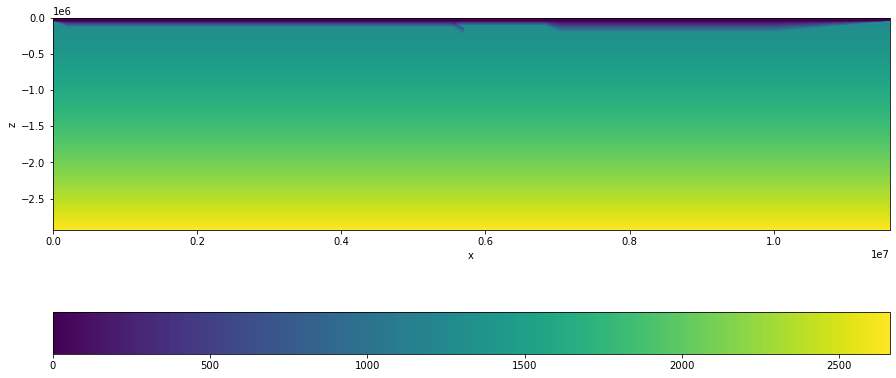

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
# Change the orientation of the color bar
cbar_kwargs = {"orientation": "horizontal"}
kwargs = {"cbar_kwargs": cbar_kwargs}

temperature.plot(y="z", **kwargs)
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
ax.set_aspect("equal")

plt.show()

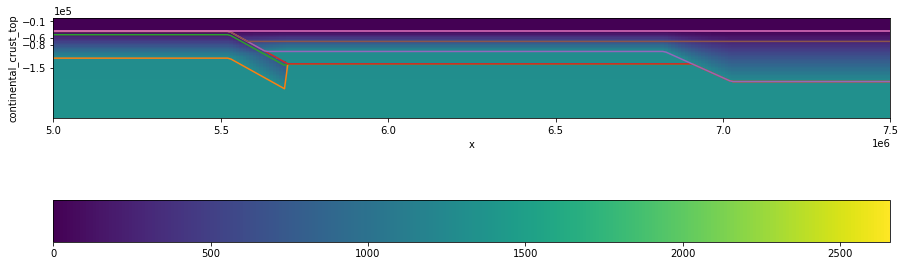

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
# Change the orientation of the color bar
cbar_kwargs = {"orientation": "horizontal"}
kwargs = {"cbar_kwargs": cbar_kwargs}

temperature.plot(y="z", **kwargs)
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
ax.set_aspect("equal")

ax.set_yticks(
    (oceanic_crust_depth, oceanic_lab_depth, arc_depth, continental_lab_depth))

for name, interface in interfaces.items():
    interface.plot.line(ax=ax, label=name)
    
plt.xlim((5000e3, 7500e3))
plt.ylim((-300e3, zmax))

#plt.plot(top.x, top.data)
#plt.plot(bottom.x, bottom.data)
plt.show()

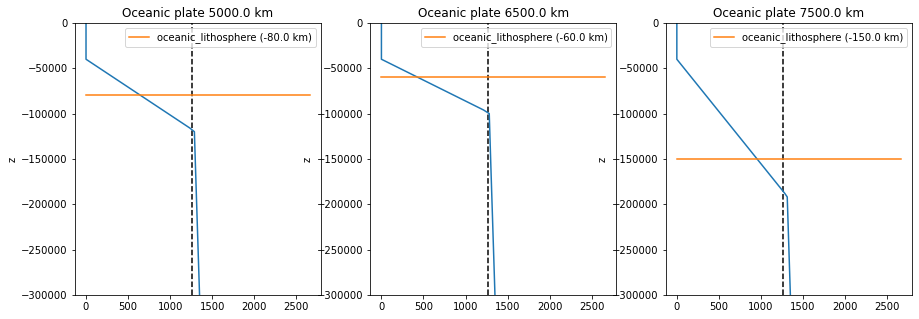

In [28]:
plt.figure(figsize=(15,5))

# temperature in the oceanic crust
plt.subplot(131)
aux = temperature.sel(x=5000e3, method="nearest") 

aux.plot(y="z")
plt.title("Oceanic plate {} km".format(aux.x.values / 1000))
plt.plot(
    aux, 
    oceanic_lab_depth * np.ones_like(aux.z),
    label="oceanic_lithosphere ({} km)".format(oceanic_lab_depth / 1e3)
)
plt.vlines(temp_0,-300_000,0, linestyles='dashed', color='k')
# plt.vlines(1300,-300_000,0, linestyles='dashed')
plt.ylim((-300e3, zmax))
# plt.ylim(-100_000,-50_000)
# plt.xlim(1000,1500)
plt.legend()

# temperature in the arc zone
plt.subplot(132)
aux = temperature.sel(x=6500e3, method="nearest") 
aux.plot(y="z")
plt.title("Oceanic plate {} km".format(aux.x.values / 1000))
plt.plot(
    aux, 
    arc_depth * np.ones_like(aux.z),
    label="oceanic_lithosphere ({} km)".format(arc_depth / 1e3)
)
plt.vlines(temp_0,-300_000,0, linestyles='dashed', color='k')
# plt.vlines(1300,-300_000,0, linestyles='dashed')
plt.ylim((-300e3, zmax))
plt.legend()

# temperature in the craton area
plt.subplot(133)
aux = temperature.sel(x=7500e3, method="nearest") 
aux.plot(y="z")
plt.title("Oceanic plate {} km".format(aux.x.values / 1000))
plt.plot(
    aux, 
    continental_lab_depth * np.ones_like(aux.z),
    label="oceanic_lithosphere ({} km)".format(continental_lab_depth / 1e3)
)
# plt.vlines(1300,-300_000,0, linestyles='dashed')
plt.vlines(temp_0,-300_000,0, linestyles='dashed', color='k')
plt.ylim((-300e3, zmax))
plt.legend()

plt.show()

**Save initial temperature distribution**

In [29]:
save_temperature(temperature, run_dir)

### Create the parameter file

In [30]:
free_surface = 'False'
if (h_air != 0):
    free_surface = 'True'
    
params = f"""# Geometry
nx                                  = {shape[0]}            # n. of nodes in the horizontal direction
nz                                  = {shape[1]}            # n. of nodes in the vertical direction
lx                                  = {xmax}       # extent in the horizontal direction
lz                                  = {-zmin}       # extent in the vertical direction 

# Simulation options
solver                              = direct        # set the solver to be direct or iterative, default is direct [direct/iterative]
denok                               = 1.0e-10       # tolerance criterion for the Uzawa's scheme, default is 1.0e-4
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0e-5
RK4                                 = Euler         # particles advection method, default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # tolerance criterion for the convergence of the non-linear flow, default is 1.0e-14
random_initial_strain               = 0.0           # non-dimensional value for the initial strain perturbation for the entire domain, default is 0.0 
pressure_const                      = -1.0          # set constant pressure value for the domain (relevant only when 2D is plain view), default is -1.0 (i.e. not used) [Pa]
initial_dynamic_range               = True         # method to smoothen convergence of the velocity field in scenarios with wide viscosity range, default is False [True/False], Gerya (2019)
periodic_boundary                   = False         # allows simulation with periodic boundary in the horizontal direction, default is False [True/False]
high_kappa_in_asthenosphere         = False         # mimics high heat transport in the asthenosphere increasing its thermal diffusivity coefficient, default is False [True/False]
basal_heat                          = -1.0          # set basal heat flux value, default is -1.0 (i.e. not used) [W/m^2]

# Particles options
particles_per_element               = {particles_per_element}          # n. of Lagrangian particles in each element, default is 81
particles_per_element_x             = 0             # n. of Lagrangian particles in the horizontal direction, default is 0 for automatic calculation
particles_per_element_z             = 0             # n. of Lagrangian particles in the vertical direction, default is 0 for automatic calculation
particles_perturb_factor            = 0.7           # indicates the amount of perturbation of the initial location of the particles relative to a regular grid distribution. Default is 0.5 [values are between 0 and 1]

# Surface processes
sp_surface_tracking                 = {free_surface}         # allows free surface tracking across time and outputs it, default is False [True/False]
sea_level                           = 0.0           # sea level used to limit the influence of the surface process, default is 0.0 [m]
sp_surface_processes                = False         # allows erosion and sedimentation simulation, default is False [True/False]
sp_dt                               = 0             # time step for surface processes simulation, default is 0 [years]
a2l                                 = True          # allows the conversion of air particles to land particles during sedimentation, default is True [True/False]
sp_mode                             = 1             # specify the surface processes method, default is 1
free_surface_stab                   = True          # set if the free surface stabilization algorithm (FSSA) is used, default is True [True/False], Kaus et al. (2010)
theta_FSSA                          = 0.5           # weight of the influence of the FSSA method, default is 0.5 (only relevant when <free_surface_stab> is True)
sticky_blanket_air                  = False         # allows the increase of viscosity for the first air layer of particles, default is False [True/False]
precipitation_profile_from_ascii    = False         # set if precipitation profile along the horizontal axis is read from an ASCII file, default is False [True/False]
climate_change_from_ascii           = False         # if True, re-scales through time the precipitation profile using an ASCII file, default is False [True/False]

# Time constrains
step_max                            = 7000          # maximum time-step of the simulation [steps]
time_max                            = 10.0e6        # maximum time of the simulation [years]
dt_max                              = 10.0e3        # maximum time between steps of the simulation [years]
step_print                          = 10            # make output files every <step_print>
sub_division_time_step              = 1.0           # re-scale value for the calculated time-step, default is 1.0
initial_print_step                  = 0             # <step_print> used until <initial_print_max_time>, default is 0 (i.e. not used)
initial_print_max_time              = 1.0e6         # maximum time to make output files every <initial_print_step>, default is 1.0e6 [years]

# Viscosity
viscosity_reference                 = 3.5e20        # reference mantle viscosity [Pa.s]
viscosity_max                       = 1.0e23        # maximum viscosity during simulation [Pa.s]
viscosity_min                       = 3.5e19        # minimum viscosity during simulation [Pa.s]
viscosity_per_element               = constant      # sets if viscosity is constant or linearly variable for every element, default is variable [constant/variable]
viscosity_mean_method               = arithmetic    # defines method do calculate the viscosity for each element, default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # defines if viscosity depends on pressure or depth, default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # set if interfaces between lithologies are read from an ASCII file (interfaces.txt), default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}             # set the number of interfaces to be read from the interfaces ASCII file (interfaces.txt) 
temperature_from_ascii              = True          # set if initial temperature is read from an ASCII file (input_temperature_0.txt), default is False [True/False]
velocity_from_ascii                 = False         # set if initial velocity field is read from an ASCII file (input_velocity_0.txt), default is False [True/False]
variable_bcv                        = False         # allows velocity field re-scaling through time according to an ASCII file (scale_bcv.txt), default is False [True/False]
multi_velocity                      = False         # set if boundary velocities can change with time from ASCII file(s) (multi_veloc.txt and additional input_velocity_[X].txt files), default is False [True/False]
binary_output                       = False         # set if output is in binary format, default is False [True/False]
print_step_files                    = True          # set if the particles position are printed to an output file, default is True [True/False]

# Physical parameters
temperature_difference              = {temperature.values.max() - temperature.values.min()}            # temperature difference between the top and bottom of the model (relevant if <temperature_from_ascii> is False) [K]
thermal_expansion_coefficient       = {alpha}       # value for the coefficient of thermal expansion [1/K]
thermal_diffusivity_coefficient     = {kappa}        # value for the coefficient of thermal diffusivity [m^2/s]
gravity_acceleration                = {g}          # value for the gravity acceleration [m/s^2]
density_mantle                      = 3230.         # value for the mantle reference density [kg/m^3]
heat_capacity                       = {heat_capacity}         # value for the heat capacity [J/K] 
non_linear_method                   = on            # set if non linear method is used for the momentum equation [on/off]
adiabatic_component                 = off           # set if adiabatic heating/cooling is active [on/off]
radiogenic_component                = off           # set if radiogenic heating is active [on/off]

# Velocity boundary conditions
top_normal_velocity                 = fixed         # set the normal velocity on the top side of the model to be fixed or free [fixed/free] 
top_tangential_velocity             = free          # set the tangential velocity on the top side of the model to be fixed or free [fixed/free]
bot_normal_velocity                 = fixed         # set the normal velocity on the bottom side of the model to be fixed or free [fixed/free]
bot_tangential_velocity             = free          # set the tangential velocity on the bot side of the model to be fixed or free [fixed/free]
left_normal_velocity                = fixed         # set the normal velocity on the left side of the model to be fixed or free [fixed/free]
left_tangential_velocity            = free          # set the tangential velocity on the left side of the model to be fixed or free [fixed/free]
right_normal_velocity               = fixed         # set the normal velocity on the right side of the model to be fixed or free [fixed/free]
right_tangential_velocity           = free          # set the tangential velocity on the right side of the model to be fixed or free [fixed/free]

# Temperature boundary conditions
top_temperature                     = fixed         # set temperature on the top side of the model to be fixed or free [fixed/free]
bot_temperature                     = fixed         # set temperature on the bottom side of the model to be fixed or free [fixed/free]
left_temperature                    = free          # set temperature on the left side of the model to be fixed or free [fixed/free]
right_temperature                   = free          # set temperature on the right side of the model to be fixed or free [fixed/free]
rheology_model                      = 19             # flag n. of a pre-defined rheology model to use during simulation
T_initial                           = 0             # flag n. of a pre-defined temperature model to use during simulation (relevant when <temperature_from_ascii> is False)
"""

# Create the parameter file
with open(os.path.join(run_dir,"param.txt"), "w") as f:
    for line in params.split("\n"):
        f.write(line + "\n")